In [4]:
import matplotlib.pyplot as plt
import matplotlib

(1024, 390)


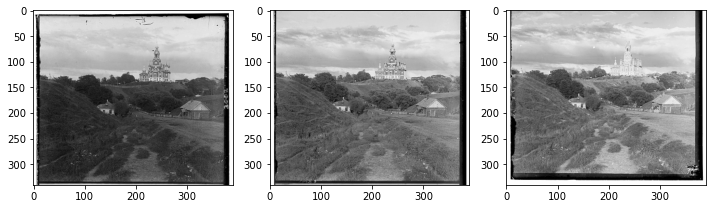

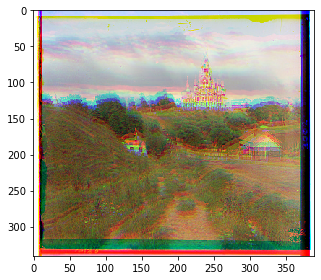

In [76]:
import numpy as np
import skimage as sk
import skimage.io as skio
import skimage.transform as sktr
import os
import time

# name of the input file
file_list = os.listdir('./data')
file_number = 0;
imname = "./data/"+file_list[file_number]
# read in the image
im = skio.imread(imname)
# convert to double (might want to do this later on to save memory)    
im = sk.img_as_float(im)

print(np.shape(im))

# compute the height of each part (just 1/3 of total)
height = np.floor(im.shape[0] / 3.0).astype(int)

# separate color channels
b = im[:height]
g = im[height: 2*height]
r = im[2*height: 3*height]

# r = sk.transform.rescale(r, 1 / 6)
# g = sk.transform.rescale(g, 1 / 6)
# b = sk.transform.rescale(b, 1 / 6)

# plot
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
ax = axes.ravel()
ax[0].imshow(b,cmap='gray')
ax[1].imshow(g,cmap='gray')
ax[2].imshow(r,cmap='gray')
fig.tight_layout()
plt.show()

#naive method
im_out = np.dstack([r, g, b])
skio.imshow(im_out)

In [83]:
# Crop image
def crop(img, ratio=0.2):
    h, w = np.floor(np.multiply(img.shape, ratio)).astype(int)
    return img[h:-h, w:-w]


# SSD method
def SSD_loss(a, b):
    loss = np.sum((a - b) ** 2)
    return loss


# NCC method
def NCC_loss(a, b):
    lossV = np.correlate((a / np.linalg.norm(a)).flatten(), (b / np.linalg.norm(b)).flatten(),'full')
    loss = np.sum(lossV)
    return loss


# align function
def align(target, ref, center=[0,0], search=[15, 15]):
    target_crop = crop(target)
    ref_crop = crop(ref)
    loss_min = float('inf')
    shift = [0, 0]
    for i in range(-search[0]+center[0], search[0]+center[0] + 1):
        for j in range(-search[1]+center[1], search[1]+center[1] + 1):
            target_shift = np.roll(target_crop, i, axis=0)
            target_shift = np.roll(target_shift, j, axis=1)
            # loss function
            loss = SSD_loss(target_shift, ref_crop)
            if (loss < loss_min):
                loss_min = loss
                shift = [i, j]
    target_final = np.roll(target, shift[0], axis=0)
    target_final = np.roll(target_final, shift[1], axis=1)
    return target_final, shift


# pyramid
def pyramid(target, ref):
    base = 2
    layer_start = 7
    layer_end = 0
    # take log2 to decide number of scales
    scale_total = np.floor(np.log(min(target.shape))/np.log(base)).astype(int)
    print("The pyramid of downsampling has " + str(scale_total) + " layers")
    print("Start from layer " + str(layer_start+1))
    shift = [0, 0]
    
    for scale in range(scale_total - layer_start, layer_end, -1):
        print("Calculate the layer of " + str(scale_total - scale + 1))
        # start from the top of the pyramid(minimum size of image)
        target_scaled = sk.transform.rescale(target, 1 / base ** scale, anti_aliasing=True)
        ref_scaled = sk.transform.rescale(ref, 1 / base ** scale, anti_aliasing=True)
        # align in current layer of pyramid
        target_temp, shift = align(target_scaled, ref_scaled, shift)
        shift = shift * base

    shift = shift*(base**layer_end)
    target_final = np.roll(target, shift[0], axis=0)
    target_final = np.roll(target_final, shift[1], axis=1)

    return target_final


The pyramid of downsampling has 8 layers
Start from layer 8
Calculate the layer of 8
(341, 390)
(170, 195)
The pyramid of downsampling has 8 layers
Start from layer 8
Calculate the layer of 8
(341, 390)
(170, 195)
The time of execution of above program is : 0.13766169548034668


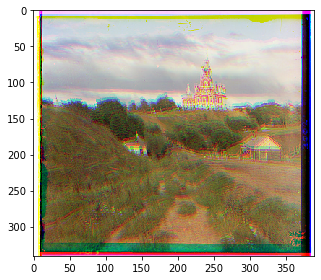

In [84]:
# align the images
# functions that might be useful for aligning the images include:
# np.roll, np.sum, sk.transform.rescale (for multiscale)

start = time.time()
# ag,shift = align(g, b)
# ar,shift = align(r, b)
ag = pyramid(g, b)
ar = pyramid(r, b)
print("The time of execution of above program is :", time.time()-start)
# create a color image
im_out = np.uint8(np.dstack([ar, ag, b])*255)
# save the image
jpgname = file_list[file_number].replace(".tif",".jpg")
fname = './output/pyramid/' + jpgname
skio.imsave(fname, im_out)

# display the image
skio.imshow(im_out)
skio.show()

In [68]:
# a = np.array([[1,2],[3,4]])
# bb = np.array([[5,6],[7,8]])



# c = []
# c.append(a)
# c.append(bb)

# print(np.correlate(a.flatten(), b.flatten(), 'full'))

# scale_total = np.floor(np.log(min(r.shape))/np.log(2)).astype(int)
# print(scale_total)
# target_scaled = sk.transform.rescale(r, 1 / 6)
# print(target_scaled.shape)
# for i in range(10,-1,-1):
#     print(i)
print(1 / 2 ** 3)

print(file_list[file_number].replace(".tif",".jpg"))

0.125
train.jpg
